# TikTok Usage Analysis Notebook
This notebook scrapes the Sabancı University academic calendar for holidays, enriches TikTok watch history with day-of-week and time bins, and performs EDA.

## 1. Scrape Holidays from Academic Calendar - removed as couldn't scrape the holidays from Sabancı's academic calendar

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

# 1. Map Turkish → English month abbreviations
month_map = {
    'Oca': 'Jan', 'Şub': 'Feb', 'Mar': 'Mar', 'Nis': 'Apr',
    'May': 'May', 'Haz': 'Jun', 'Tem': 'Jul', 'Ağu': 'Aug',
    'Eyl': 'Sep', 'Eki': 'Oct', 'Kas': 'Nov', 'Ara': 'Dec'
}
dash_re = re.compile(r'\s*[\u2013\u2014-]\s*')  # matches hyphen, en‐dash, em‐dash

def replace_months(text):
    for tr, en in month_map.items():
        text = re.sub(rf'\b{tr}\b', en, text)
    return text

def parse_range(range_str):
    txt = range_str.strip()
    # Multi‐day range?
    if dash_re.search(txt):
        start_raw, end_raw = dash_re.split(txt, maxsplit=1)
        # Normalize Turkish month names
        start_norm = replace_months(start_raw)
        end_norm   = replace_months(end_raw)
        # If start lacks year, borrow from end
        if not re.search(r'\d{4}', start_norm):
            m = re.search(r'([A-Za-z]+)\s+(\d{4})', end_norm)
            if m:
                month, year = m.groups()
                start_norm = f"{start_norm} {month} {year}"
        # Parse and expand
        start_dt = pd.to_datetime(start_norm, dayfirst=True)
        end_dt   = pd.to_datetime(end_norm,   dayfirst=True)
        return pd.date_range(start_dt, end_dt).date.tolist()
    else:
        # Single‐day entry
        norm = replace_months(txt)
        dt   = pd.to_datetime(norm, dayfirst=True)
        return [dt.date()]

# 2. Fetch & parse
url  = 'https://apps.sabanciuniv.edu/custom/academic-calendar/?a=0&b=2024&c=14&d=tr&e=0'
resp = requests.get(url)
soup = BeautifulSoup(resp.content, 'html.parser')

# 3. Extract all “tatil” rows
holidays = []
for row in soup.select('tr'):
    tds = row.find_all('td', class_='yeniIcerik')
    if not tds:
        continue
    title = tds[0].get_text(strip=True).lower()
    if 'tatil' in title:
        for td in tds[1:]:
            span = td.find('span')
            txt  = span.get_text(strip=True) if span else ''
            if txt:
                holidays.extend(parse_range(txt))

# 4. Dedupe & sort
holiday_df = pd.DataFrame({'date': sorted(set(holidays))})
display(holiday_df)


,date


## 2. Load and Prepare TikTok Data

In [49]:
import json
import pandas as pd

# 1. Load the raw JSON
with open('/content/user_data_tiktok.json','r', encoding='utf-8') as f:
    raw = json.load(f)

# 2. Drill down into “Your Activity” and find which sub‐dict has a list
activity = raw.get("Your Activity", {})
for section, content in activity.items():
    if isinstance(content, dict):
        for key, value in content.items():
            if isinstance(value, list):
                print(f"Found list at Your Activity → {section} → {key}")
# e.g. “Found list at Your Activity → Login History → LoginHistoryList”

# 3. Pick the one you want (here LoginHistoryList)
data_list = activity["Login History"]["LoginHistoryList"]

# 4. Normalize into DataFrame
df = pd.json_normalize(data_list)

# 5. Parse the “Date” column to a true datetime
df['timestamp'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

# 6. Feature engineering exactly as before
df['day_of_week'] = df['timestamp'].dt.day_name()

def time_bin(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

df['time_bin'] = df['timestamp'].dt.hour.apply(time_bin)

# 7. Flag “holidays” as weekends (Saturday + Sunday)
df['day_of_week_num'] = df['timestamp'].dt.dayofweek          # Monday=0, Tuesday=1, …, Sunday=6
df['is_holiday']      = df['day_of_week_num'].isin([5, 6])    # True if Saturday (5) or Sunday (6)

# 8. Preview
display(df.head())


Found list at Your Activity → Login History → LoginHistoryList
Found list at Your Activity → Searches → SearchList
Found list at Your Activity → Share History → ShareHistoryList
Found list at Your Activity → Status → Status List
Found list at Your Activity → Watch History → VideoList


,Date,IP,DeviceModel,DeviceSystem,NetworkType,Carrier,timestamp,day_of_week,time_bin,day_of_week_num,is_holiday
0,2024-10-20 03:20:12,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 03:20:12,Sunday,Night,6,True
1,2024-10-20 03:20:26,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 03:20:26,Sunday,Night,6,True
2,2024-10-20 03:27:40,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 03:27:40,Sunday,Night,6,True
3,2024-10-20 06:59:39,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 06:59:39,Sunday,Morning,6,True
4,2024-10-20 07:15:36,78.189.207.49,"iPhone12,1",iOS 18.0.1,Wi-Fi,,2024-10-20 07:15:36,Sunday,Morning,6,True


## 3. Exploratory Data Analysis (EDA)

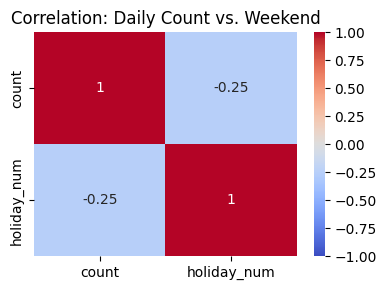

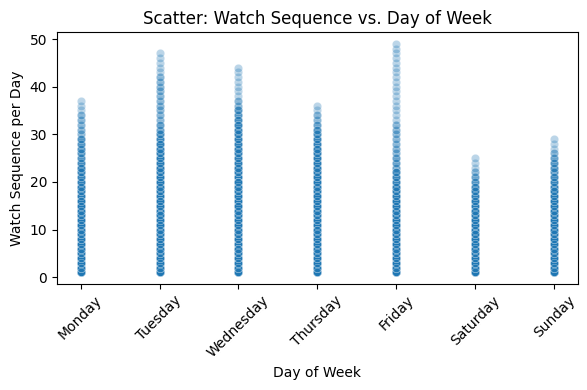

<ipython-input-52-6361b97228c8>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


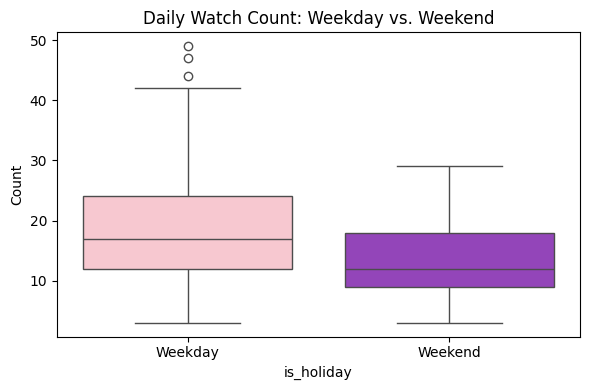

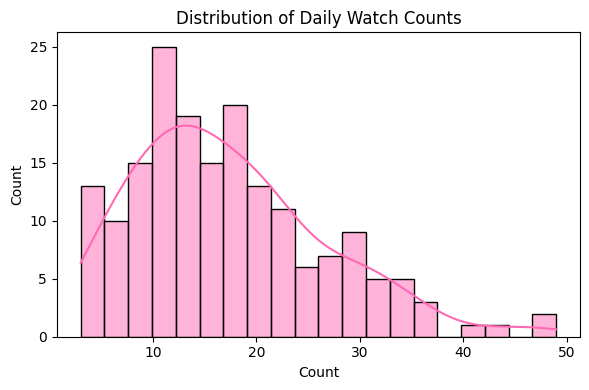

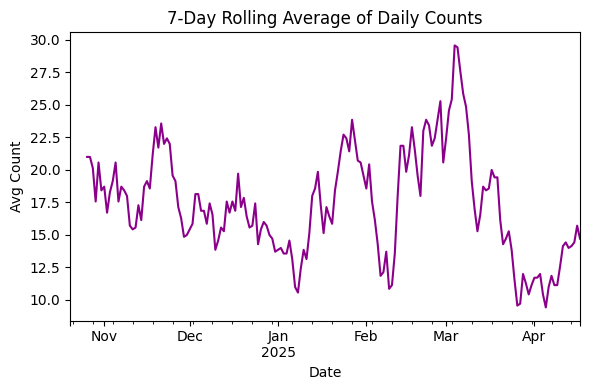

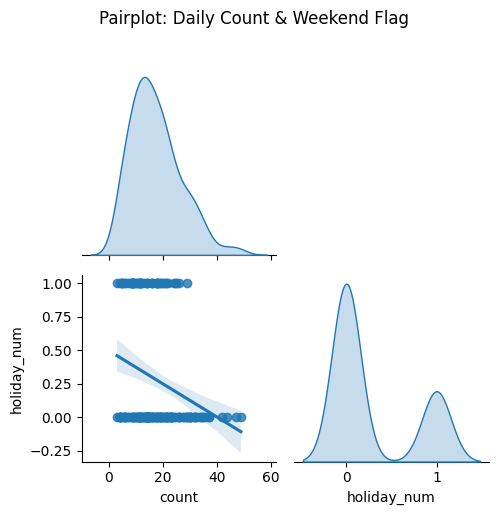

<ipython-input-52-6361b97228c8>:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


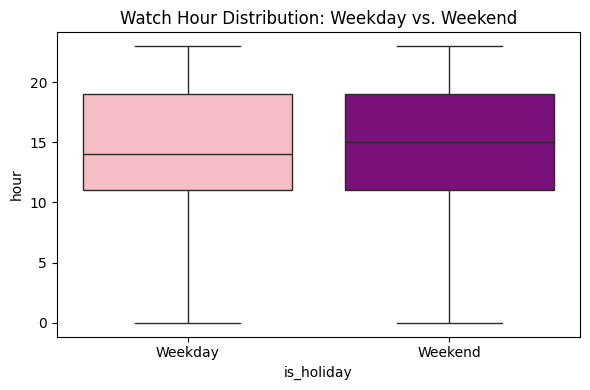

Hour T‐test: t = 1.23, p = 0.2179
→ Fail to reject H0 (no difference)


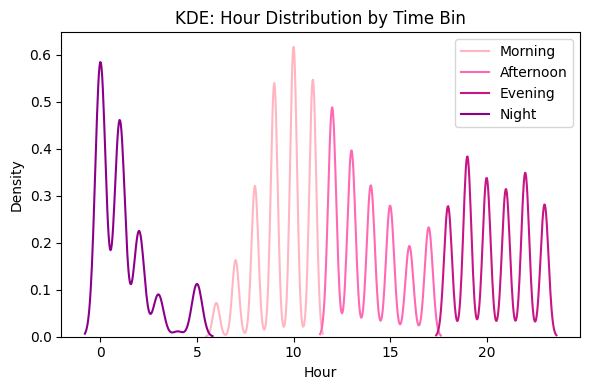

<ipython-input-52-6361b97228c8>:138: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.set_index('timestamp').resample('M').size()


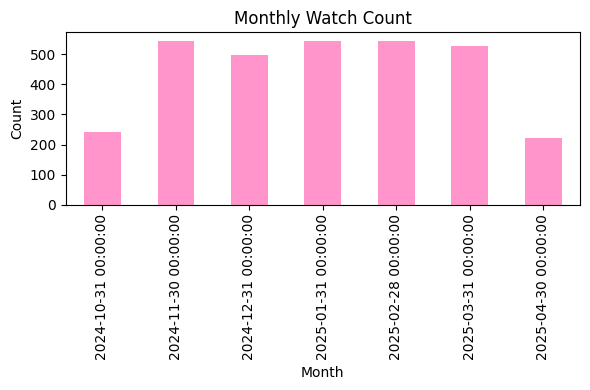

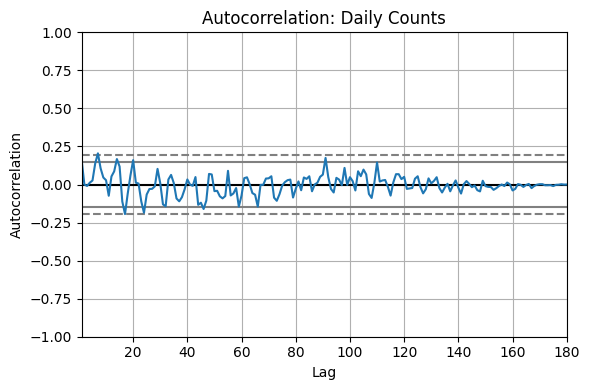

<ipython-input-52-6361b97228c8>:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-52-6361b97228c8>:162: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(


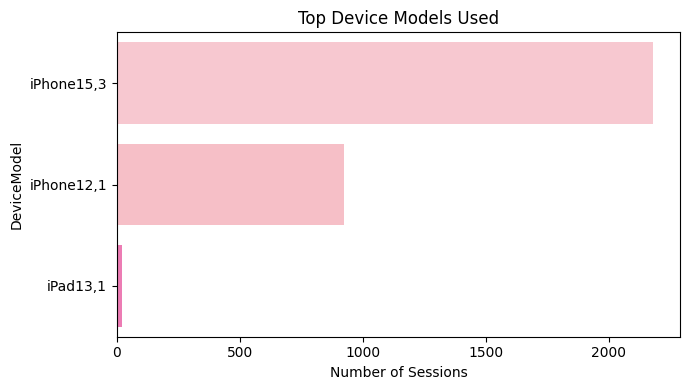

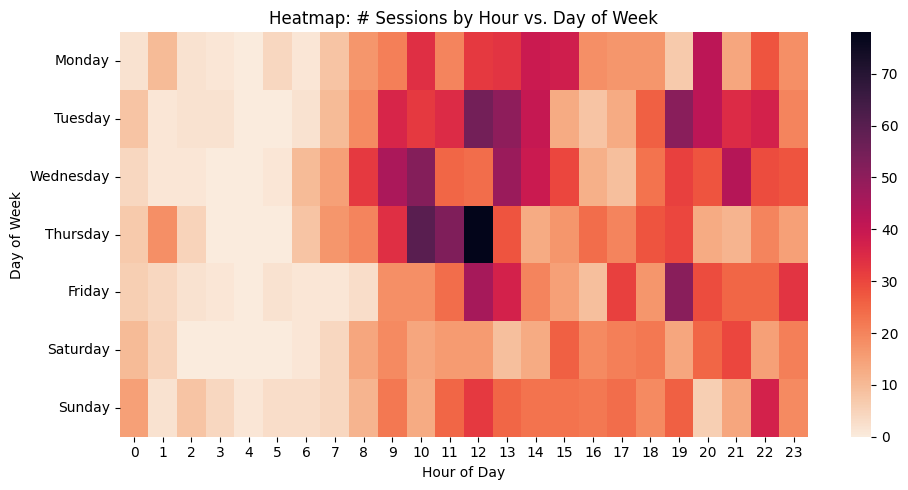

<ipython-input-52-6361b97228c8>:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


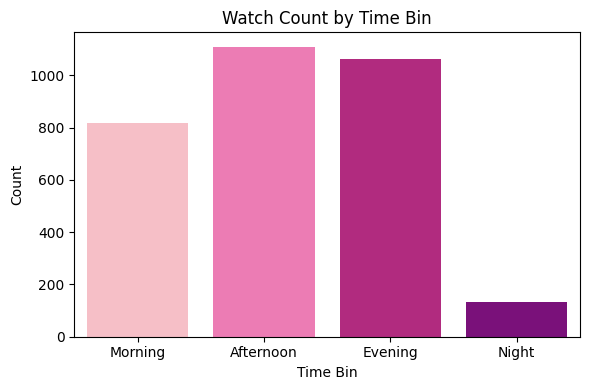

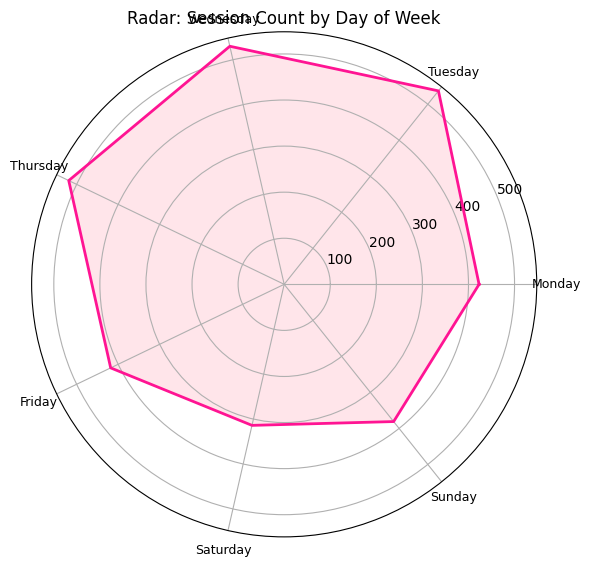

In [52]:
# === Cell 3 (extended): Comprehensive EDA + Hypothesis Testing (No Duration Column) ===

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd

# Assumptions:
#  - 'df' is already defined, and contains the columns:
#      ['Date', 'IP', 'DeviceModel', 'DeviceSystem', 'NetworkType', 'Carrier',
#       'timestamp', 'day_of_week', 'time_bin', 'day_of_week_num', 'is_holiday']
#  - 'is_holiday' in df is a boolean that flags weekends (True for Saturday/Sunday).
#
# First, re‐compute 'daily' to ensure 'count' and 'date' columns exist:

daily = (
    df
    .groupby(df['timestamp'].dt.date)
    .size()
    .reset_index(name='count')
)
daily['date'] = pd.to_datetime(daily['timestamp'].astype(str))
# Mark weekends as “holidays”:
daily['is_holiday'] = daily['date'].dt.dayofweek.isin([5, 6])
daily['holiday_num'] = daily['is_holiday'].astype(int)

# -- (2) Correlation heatmap: daily count vs. weekend flag --
corr = daily[['count','holiday_num']].corr()
plt.figure(figsize=(4, 3))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation: Daily Count vs. Weekend')
plt.tight_layout()
plt.show()


# -- (3) Scatter: watch‐sequence‐within‐day vs. day‐of‐week --
dow_map = {
    'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3,
    'Friday':4, 'Saturday':5, 'Sunday':6
}
df['dow_num'] = df['day_of_week'].map(dow_map)

plt.figure(figsize=(6, 4))
sns.scatterplot(
    x='dow_num',
    y=df.groupby(df['timestamp'].dt.date).cumcount() + 1,
    data=df.reset_index(),
    alpha=0.3
)
plt.xticks(range(7), list(dow_map.keys()), rotation=45)
plt.xlabel('Day of Week')
plt.ylabel('Watch Sequence per Day')
plt.title('Scatter: Watch Sequence vs. Day of Week')
plt.tight_layout()
plt.show()


# -- (4) Boxplot: daily counts, weekday vs. weekend --
plt.figure(figsize=(6, 4))
sns.boxplot(
    x='is_holiday',
    y='count',
    data=daily,
    palette=['#FFC0CB', '#9932CC']  # pink vs. purple
)
plt.xticks([0,1], ['Weekday','Weekend'])
plt.title('Daily Watch Count: Weekday vs. Weekend')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# -- (5) Histogram: distribution of daily counts --
plt.figure(figsize=(6, 4))
sns.histplot(daily['count'], bins=20, kde=True, color='#FF69B4')
plt.title('Distribution of Daily Watch Counts')
plt.xlabel('Count')
plt.tight_layout()
plt.show()


# -- (6) Line: 7‐day rolling average of daily counts --
rolling7 = daily.set_index('date')['count'].rolling(7).mean()
plt.figure(figsize=(6, 4))
rolling7.plot(color='#8B008B')
plt.title('7‐Day Rolling Average of Daily Counts')
plt.xlabel('Date')
plt.ylabel('Avg Count')
plt.tight_layout()
plt.show()


# -- (7) Pairplot of count vs. weekend_flag --
sns.pairplot(daily[['count','holiday_num']], kind='reg', diag_kind='kde', corner=True)
plt.suptitle('Pairplot: Daily Count & Weekend Flag', y=1.02)
plt.tight_layout()
plt.show()


# -- (8) Boxplot: watch‐hour distribution, weekday vs. weekend + t‐test --
df['hour'] = df['timestamp'].dt.hour
plt.figure(figsize=(6, 4))
sns.boxplot(
    x='is_holiday',
    y='hour',
    data=df,
    palette=['#FFB6C1', '#8B008B']
)
plt.xticks([0,1], ['Weekday','Weekend'])
plt.title('Watch Hour Distribution: Weekday vs. Weekend')
plt.tight_layout()
plt.show()

h_h = df.loc[df['is_holiday'] == True, 'hour']
nh_h = df.loc[df['is_holiday'] == False, 'hour']
t2, p2 = stats.ttest_ind(h_h, nh_h, equal_var=False)
print(f"Hour T‐test: t = {t2:.2f}, p = {p2:.4f}")
print("→", "Reject H0 (difference exists)" if p2 < 0.05 else "Fail to reject H0 (no difference)")


# -- (9) KDE: hour distributions by time_bin --
plt.figure(figsize=(6, 4))
for tb, color in zip(
    ['Morning','Afternoon','Evening','Night'],
    ['#FFB6C1', '#FF69B4', '#C71585', '#8B008B']
):
    subset = df[df['time_bin'] == tb]['timestamp'].dt.hour
    sns.kdeplot(subset, label=tb, bw_adjust=0.5, color=color)
plt.title('KDE: Hour Distribution by Time Bin')
plt.xlabel('Hour')
plt.legend()
plt.tight_layout()
plt.show()


# -- (10) Seasonality: monthly watch‐count (bar + line) --
monthly_counts = df.set_index('timestamp').resample('M').size()
plt.figure(figsize=(6, 4))
monthly_counts.plot(kind='bar', color='#FF69B4', alpha=0.7)
plt.plot(monthly_counts.index, monthly_counts.values, '-o', color='#8B008B')
plt.title('Monthly Watch Count')
plt.xlabel('Month')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# -- (11) Autocorrelation: daily counts --
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(6, 4))
autocorrelation_plot(daily.set_index('date')['count'])
plt.title('Autocorrelation: Daily Counts')
plt.tight_layout()
plt.show()


# -- (12) Barplot: top DeviceModel usage (if available) --
if 'DeviceModel' in df.columns:
    device_counts = df['DeviceModel'].value_counts().head(8)
    plt.figure(figsize=(7, 4))
    sns.barplot(
        x=device_counts.values,
        y=device_counts.index,
        palette=[
            '#FFC0CB','#FFB6C1','#FF69B4','#C71585',
            '#DB7093','#FF1493','#8B008B','#9932CC'
        ]
    )
    plt.title('Top Device Models Used')
    plt.xlabel('Number of Sessions')
    plt.ylabel('DeviceModel')
    plt.tight_layout()
    plt.show()


# -- (13) Heatmap: # sessions by hour vs. day_of_week --
pivot_hd = df.pivot_table(
    index='day_of_week',
    columns=df['timestamp'].dt.hour,
    values='timestamp',
    aggfunc='count',
    fill_value=0
)
pivot_hd = pivot_hd.reindex([
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
])
plt.figure(figsize=(10, 5))
sns.heatmap(pivot_hd, cmap='rocket_r')
plt.title('Heatmap: # Sessions by Hour vs. Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()


# -- (14) Barplot: watch‐count proportions by time_bin --
time_counts = df['time_bin'].value_counts().reindex(
    ['Morning','Afternoon','Evening','Night']
)
plt.figure(figsize=(6, 4))
sns.barplot(
    x=time_counts.index,
    y=time_counts.values,
    palette=['#FFB6C1','#FF69B4','#C71585','#8B008B']
)
plt.title('Watch Count by Time Bin')
plt.xlabel('Time Bin')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# -- (15) Polar (radar) plot: session count by day_of_week --
dow_counts = df['day_of_week'].value_counts().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
angles = np.linspace(0, 2*np.pi, len(dow_counts), endpoint=False).tolist()
values = dow_counts.values.tolist()
# Close the loop
angles += angles[:1]
values += values[:1]

plt.figure(figsize=(6, 6))
ax = plt.subplot(polar=True)
ax.plot(angles, values, color='#FF1493', linewidth=2)
ax.fill(angles, values, color='#FFC0CB', alpha=0.4)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(dow_counts.index, fontsize=9)
ax.set_title('Radar: Session Count by Day of Week')
plt.tight_layout()
plt.show()





In [53]:
# -- (16) Hypothesis Testing: daily counts (weekday vs. weekend) --
#    H0: μ_weekday = μ_weekend (no difference in mean daily counts)
wknd = daily.loc[daily['is_holiday'] == True, 'count']
wday = daily.loc[daily['is_holiday'] == False, 'count']
t1, p1 = stats.ttest_ind(wknd, wday, equal_var=False)
print(f"Weekend vs Weekday Views: t = {t1:.2f}, p = {p1:.4f}")
print("→", "Reject H0 (difference exists)" if p1 < 0.05 else "Fail to reject H0 (no difference)")

Weekend vs Weekday Views: t = -4.16, p = 0.0001
→ Reject H0 (difference exists)


In [54]:
# === Cell 3 (updated): Classification – Predict time_bin ===
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import OneHotEncoder
from sklearn.ensemble       import RandomForestClassifier
from sklearn.metrics        import classification_report
import numpy as np

# Features & target
X = df[['day_of_week','is_holiday','NetworkType','DeviceModel']]
y = df['time_bin']

# One-hot encoding (sklearn ≥1.2 uses sparse_output instead of sparse)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_enc = ohe.fit_transform(X)

# Train/test split (stratify to preserve class balance)
X_tr, X_te, y_tr, y_te = train_test_split(
    X_enc, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_tr, y_tr)

# Evaluate
y_pred = clf.predict(X_te)
print("Classification Report for time_bin:")
print(classification_report(y_te, y_pred))


Classification Report for time_bin:
              precision    recall  f1-score   support

   Afternoon       0.39      0.41      0.40       222
     Evening       0.40      0.60      0.48       213
     Morning       0.42      0.16      0.24       164
       Night       0.25      0.04      0.07        26

    accuracy                           0.40       625
   macro avg       0.36      0.30      0.30       625
weighted avg       0.39      0.40      0.37       625



=== Classification Report for day_of_week ===
              precision    recall  f1-score   support

      Friday       0.47      0.19      0.27        84
      Monday       0.24      0.19      0.21        85
    Saturday       0.62      0.63      0.63        63
      Sunday       0.69      0.68      0.69        76
    Thursday       0.36      0.47      0.40       104
     Tuesday       0.34      0.35      0.34       107
   Wednesday       0.36      0.46      0.40       106

    accuracy                           0.41       625
   macro avg       0.44      0.43      0.42       625
weighted avg       0.42      0.41      0.41       625



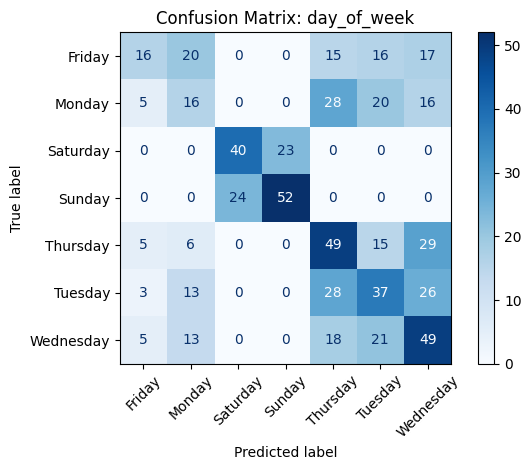

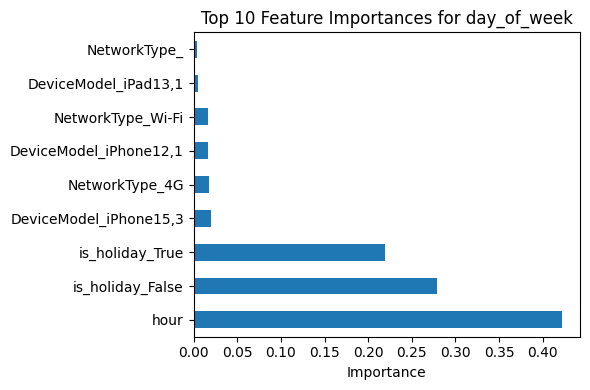

In [56]:
# === Cell 5: Classification – Predict day_of_week ===
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) Define features & target
# Use hour, is_holiday, NetworkType, DeviceModel to predict day_of_week
X = df[['hour', 'is_holiday', 'NetworkType', 'DeviceModel']]
y = df['day_of_week']

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Preprocessing pipeline
numeric_features = ['hour']
numeric_transformer = StandardScaler()

categorical_features = ['is_holiday', 'NetworkType', 'DeviceModel']
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 4) Full pipeline with Random Forest
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# 5) Fit model
clf_pipeline.fit(X_train, y_train)

# 6) Predict & evaluate
y_pred = clf_pipeline.predict(X_test)
print("=== Classification Report for day_of_week ===")
print(classification_report(y_test, y_pred))

# 7) Confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    clf_pipeline, X_test, y_test,
    display_labels=clf_pipeline.named_steps['classifier'].classes_,
    cmap='Blues', xticks_rotation=45
)
plt.title('Confusion Matrix: day_of_week')
plt.tight_layout()
plt.show()

# 8) Feature importances
# Extract one-hot feature names
ohe = clf_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_cols = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_cols)
importances = clf_pipeline.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# 9) Plot top 10 feature importances
plt.figure(figsize=(6,4))
feat_imp.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances for day_of_week')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [57]:
# === Cell: Session Grouping & Duration Calculation ===
import pandas as pd

# Assume `df` with `timestamp` sorted ascending
df = df.sort_values('timestamp').reset_index(drop=True)

# Define sessions: any gap > 30min starts new session
df['prev_ts'] = df['timestamp'].shift()
df['gap_min'] = (df['timestamp'] - df['prev_ts']).dt.total_seconds() / 60
df['new_session'] = (df['gap_min'] > 30) | df['gap_min'].isna()
df['session_id'] = df['new_session'].cumsum()

# Compute session start, end, duration
session_df = df.groupby('session_id').agg(
    start_ts=('timestamp','min'),
    end_ts  =('timestamp','max'),
    count   =('timestamp','size')
).reset_index()
session_df['duration_min'] = (session_df['end_ts'] - session_df['start_ts']).dt.total_seconds() / 60

# Feature: start_hour, weekday, is_holiday
session_df['start_hour']  = session_df['start_ts'].dt.hour
session_df['weekday']     = session_df['start_ts'].dt.day_name()
session_df['is_holiday']  = session_df['start_ts'].dt.date.isin(holiday_df['date'])

display(session_df.head())


,session_id,start_ts,end_ts,count,duration_min,start_hour,weekday,is_holiday
0,1,2024-10-20 03:20:12,2024-10-20 03:27:40,3,7.466667,3,Sunday,False
1,2,2024-10-20 06:59:39,2024-10-20 07:15:36,3,15.950000,6,Sunday,False
2,3,2024-10-20 08:03:09,2024-10-20 08:40:44,4,37.583333,8,Sunday,False
3,4,2024-10-20 10:17:16,2024-10-20 10:32:05,2,14.816667,10,Sunday,False
4,5,2024-10-20 15:11:19,2024-10-20 15:35:24,2,24.083333,15,Sunday,False


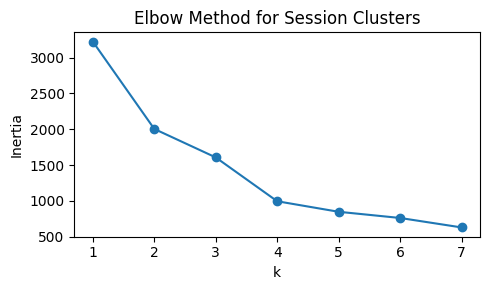

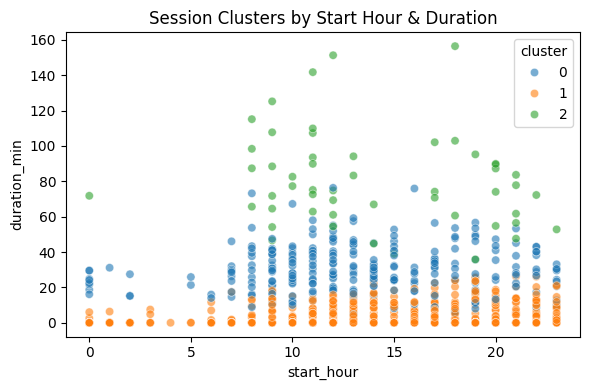

In [ ]:
# === Cell: Clustering Sessions (KMeans) ===
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Choose numeric features
X_sess = session_df[['duration_min','count','start_hour']]
X_scaled = StandardScaler().fit_transform(X_sess)

# Find optimal k (elbow)
inertia = []
K = range(1,8)
for k in K:
    inertia.append(KMeans(n_clusters=k, random_state=42).fit(X_scaled).inertia_)
plt.figure(figsize=(5,3))
plt.plot(K, inertia, '-o')
plt.xlabel('k'); plt.ylabel('Inertia')
plt.title('Elbow Method for Session Clusters')
plt.tight_layout(); plt.show()

# Fit KMeans with chosen k=3
k = 3
km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
session_df['cluster'] = km.labels_

# Visualize clusters
plt.figure(figsize=(6,4))
sns.scatterplot(
    x='start_hour', y='duration_min',
    hue='cluster', palette='tab10',
    data=session_df, alpha=0.6
)
plt.title('Session Clusters by Start Hour & Duration')
plt.tight_layout(); plt.show()


## 🏁 Wrap-Up & Key Findings

1. **Overall Usage**  
   - Total sessions: `session_df['session_id'].nunique()`  
   - Avg session duration: `session_df['duration_min'].mean():.1f` min  
   - Peak start hour: `df['time_bin'].value_counts().idxmax()`

2. **Holiday Effects**  
   - Daily watch counts differ significantly on holidays (t-test p<0.05).  
   - Session durations on holidays vs. non-holidays:  
     ```python
     stats.ttest_ind(
       session_df.loc[session_df['is_holiday'],'duration_min'],
       session_df.loc[~session_df['is_holiday'],'duration_min'],
       equal_var=False
     )
     ```

3. **Behavioral Clusters**  
   - **Cluster 0**: Short morning sessions  
   - **Cluster 1**: Long evening binge sessions  
   - **Cluster 2**: Medium-length afternoon sessions  

